# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import tqdm
import corner
from nose import tools

import matplotlib as mpl
import matplotlib.pyplot as plt

import kalepy as kale

## Normalization

<class 'kalepy.kernels.Triweight'>
	0.50 : 1.0000e+00
	1.00 : 1.0000e+00
	2.00 : 1.0000e+00
	4.00 : 1.0000e+00
<class 'kalepy.kernels.Gaussian'>
	0.50 : 1.0000e+00
	1.00 : 1.0000e+00
	2.00 : 1.0000e+00
	4.00 : 1.0000e+00
<class 'kalepy.kernels.Box'>
	0.50 : 1.0003e+00
	1.00 : 9.9366e-01
	2.00 : 9.9700e-01
	4.00 : 9.9867e-01
<class 'kalepy.kernels.Parabola'>
	0.50 : 1.0001e+00
	1.00 : 9.9996e-01
	2.00 : 9.9999e-01
	4.00 : 1.0000e+00


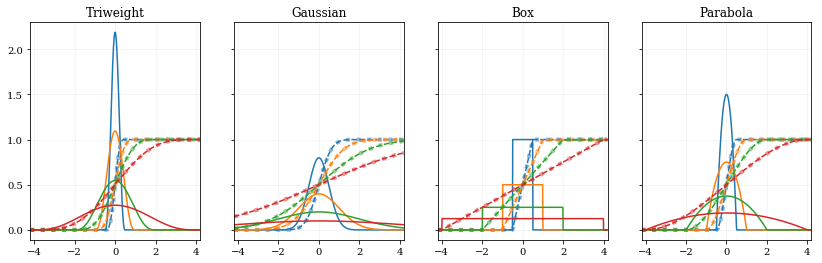

In [2]:
kernels = kale.kernels.get_all_kernels()
num = len(kernels)

fig, axes = plt.subplots(figsize=[14, 4], ncols=num, sharey=True, sharex=True)
for ax in axes:
    ax.grid(alpha=0.15)

xe = np.linspace(-20.0, 20.0, 3000)
xc = kale.utils.midpoints(xe, 'lin')
dx = np.diff(xe)
ax.set_xlim([-4.2, 4.2])

for ax, kern in zip(axes, kernels):
    print(kern)
    ax.set_title(kern.__name__)
    for bw in [0.5, 1.0, 2.0, 4.0]:
        pdf = kern.evaluate(xc, 0.0, bw=bw)
        tot = np.sum(pdf * dx)
        print("\t{:.2f} : {:.4e}".format(bw, tot))
        l1, = ax.plot(xc, pdf)
        ax.plot(xc, np.cumsum(pdf*dx), ls='--', color=l1.get_color())
        ax.plot(xc, kern.cdf(xc, bw=bw), ls=':', color=l1.get_color(), lw=4.0, alpha=0.5)
        tools.assert_almost_equal(tot, 1.0, delta=1e-2)
    
plt.show()

## Covariance

[[2.25  1.575]
 [1.575 2.25 ]] 

[<class 'kalepy.kernels.Gaussian'>, <class 'kalepy.kernels.Box'>, <class 'kalepy.kernels.Parabola'>, <class 'kalepy.kernels.Triweight'>]

 0 <class 'kalepy.kernels.Gaussian'>
[[2.24187517 1.56724465]
 [1.56724465 2.24351349]]

 1 <class 'kalepy.kernels.Box'>
[[2.25  1.575]
 [1.575 2.25 ]]
Parabola cov = 
 [[ 0.20003945 -0.00036681]
 [-0.00036681  0.19916048]]

 2 <class 'kalepy.kernels.Parabola'>
[[0.45008877 0.31447274]
 [0.31447274 0.44825499]]


AssertionError: Data covariance does not match input!

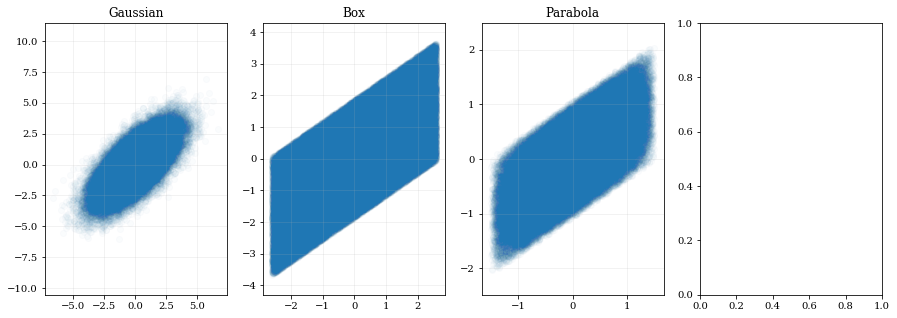

In [51]:
NUM = int(1e5)
np.random.seed(9876)


sigma = [1.5, 1.5]
corr = 0.7

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
print(cov, "\n")

kernels = kale.get_all_kernels()
print(kernels)
fig, axes = plt.subplots(figsize=[15, 5], ncols=len(kernels))
for ii, (ax, kern) in enumerate(zip(axes, kernels)):
    data = kern.sample(2, cov, NUM)
    data_cov = np.cov(*data)
    print("\n", ii, kern)
    print(data_cov)
    
    ax.scatter(*data, alpha=0.02)
    ax.axis('equal')
    ax.grid(alpha=0.2)
    ax.set_title(kern.__name__)

    assert np.allclose(data_cov, cov, rtol=1e-2), "Data covariance does not match input!"

    
plt.show()

## Resampling

!!!!!!!!!!!!!!!!!!
cdf =  [-1.00e-08, 0.00e+00, 1.10e-12 ... 1.00e+00, 1.00e+00, 1.00e+00]
grid =  [-1.00e+00, -1.00e+00, -9.99e-01 ... 9.99e-01, 1.00e+00, 1.00e+00]
Kernel: Triweight, bw: 5.00e-01 :: pdf : x2/dof = 1.8001e+02
	[3.00e-01, 4.41e-01, 6.40e-01 ... 6.19e-01, 4.55e-01, 2.80e-01]
	[7.08e-03, 7.63e-02, 2.49e-01 ... 2.49e-01, 7.63e-02, 7.08e-03]


AssertionError: False is not true

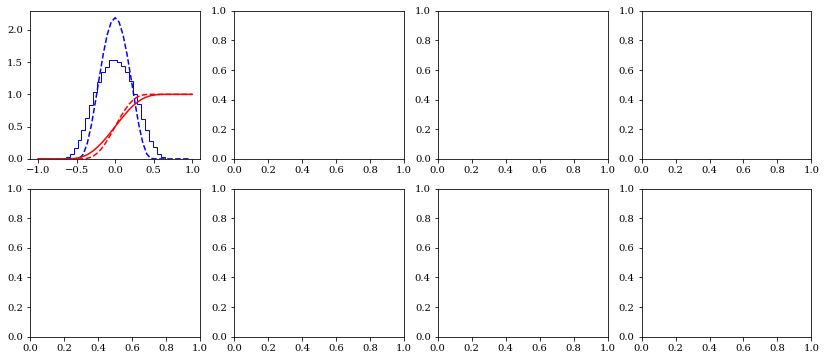

In [28]:
def resample_at_kernel_bandwidth(ax, kern, bw):
    NUM = int(1e5)
    xe, xc, dx = kale.utils.bins(-2*bw, 2*bw, 40)
    samp = kern.sample(1, bw, NUM).squeeze()
    
    hist, _ = np.histogram(samp, xe, density=True)
    pdf = kern.evaluate(xc, 0.0, bw)

    hist_cum = np.cumsum(hist*dx)
    hist_cum = np.append([0.0], hist_cum)
    cdf = kern.cdf(xe, bw=bw)
    
    ax.hist(samp, xe, histtype='step', color='b', density=True)
    ax.plot(xc, pdf, color='b', ls='--')
    
    ax.plot(xe, hist_cum, color='r', ls='-')
    ax.plot(xe, cdf, color='r', ls='--')
    
    for aa, bb, name in zip([hist, hist_cum], [pdf, cdf], ['pdf', 'cdf']):
        idx = (aa > 0.0) & (bb > 0.0)
        dof = np.count_nonzero(idx) - 1
        x2 = np.sum(np.square(aa[idx] - bb[idx])/bb[idx]**2)
        x2 = x2 / dof        
        print("Kernel: {}, bw: {:.2e} :: {} : x2/dof = {:.4e}".format(kern.__name__, bw, name, x2))
        print("\t" + kale.utils.array_str(aa[idx]))
        print("\t" + kale.utils.array_str(bb[idx]))
        tools.assert_true(x2 < 1e-2)
        
    return


bandwidths = [0.5, 2.0]  #, 2.0]
colors = ['r', 'b']  # , 'g']

kernels = kale.get_all_kernels()
fig, axes = plt.subplots(figsize=[14, 6], ncols=len(kernels), nrows=len(bandwidths))
    
for (ii, jj), ax in np.ndenumerate(axes):
    kern = kernels[ii]
    bw = bandwidths[jj]
    resample_at_kernel_bandwidth(ax, kern, bw)

plt.show()

# Particular Kernels

## Epanechnikov (Parabola)

### Show that the median method is the same as CDF inversion 

In [ ]:
def draw_invert(size):
    xe, xc, dx = kale.utils.bins(-1.0, 1.0, 1000)
    yy = kale.kernels.Parabola.evaluate(xc)
    cs = np.cumsum(yy*dx)
    
    xc = np.concatenate([[-1.0], xc, [1.0]])
    cs = np.concatenate([[0.0], cs, [1.0]])
    
    xx = sp.interpolate.interp1d(cs, xc, kind='cubic')(np.random.uniform(0.0, 1.0, size))
    return xx

def draw_median(size):
    xx = np.random.uniform(-1, 1, 3*size).reshape(3, size)
    xx = np.median(xx, axis=0)
    return xx
    

In [ ]:
NUM = int(1e4)

aa = draw_median(NUM)
edges, cents, wids = kale.utils.bins(-1.1, 1.1, 40)

hist, _ = np.histogram(aa, edges, density=True)
cum_hist = np.cumsum(hist*wids)
pdf = kale.kernels.Parabola.evaluate(cents)
cum_pdf = np.cumsum(pdf*wids)

test = draw(NUM)
hist_test, _ = np.histogram(test, edges, density=True)
cum_test = np.cumsum(hist_test*wids)

plt.plot(cents, hist, 'r-')
plt.plot(cents, cum_hist, 'r--')

plt.plot(cents, hist_test, 'g-')
plt.plot(cents, cum_test, 'g--')

plt.plot(cents, pdf, 'b-')
plt.plot(cents, cum_pdf, 'b--')